In [44]:
import gurobipy as gb
import networkx as nx
import matplotlib.pyplot as plt
import os


#
# Drawing 
# functions
#


def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=200,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
        

    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=200,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        


        
        
    
    plt.axis('off')
    plt.show()


def DrawSubtour (G, x, subtour):

    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}


    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=200,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
    
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o',
                           nodelist=subtour,
                           node_size=200,
                           node_color='white',
                           edgecolors='black',
                           label=[G.nodes()])
        
    

    nx.draw_networkx_labels(G, pos=pos, font_color='k', font_size=8)
    
    
    subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]
    
    for u,v in subtouredges:
        if x[u,v].x > 0.01 and x[u,v].x < 0.99:

            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],
                                   edge_color='r')

            nx.draw_networkx_edge_labels(G, pos=pos, 
                                         edge_labels={(u,v):f'[{x[u,v].x:.2f}, {x[v,u].x:.2f}]'})

            
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,\
                                   edgelist=[(u,v)],\
                                   edge_color='k')
            
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    scale = 15
    figsize = (10,10)

## mTSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> A set of routes for $m$ salesmen who all start from and turn back to a home city (depot, node 1) 
 


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} c_{ij} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N \setminus \{1\}, |S| \ge 2 \;\; \text{(SEC)}\\
\text {or}\\
\sum_{(i,j) \in \delta^+(S)} x_{ij} &\ge 1 \;\; \forall S \subset N, \{1\} \in S\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [45]:
# 
# Read the graph in the graphML format
#


args.filename = 'mtsp_graph.graphml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

args.figsize = (10,10)

#print(G.edges(data=True))

G has 100 nodes and 4950 edges
False


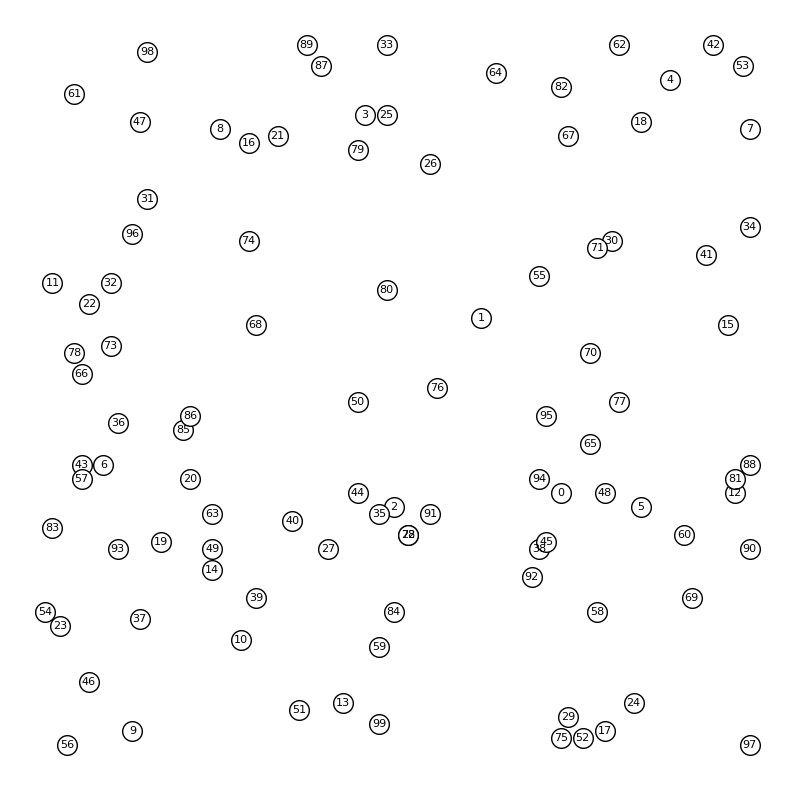

In [46]:
root = list(G.nodes())[0]

DrawInitG(G)



## mTSP: Branch-and-cut

In [47]:
m = 3

G.edges()

G.edges(data=True)

EdgeDataView([(0, 1, {'dist': 27.313000567495326}), (0, 2, {'dist': 23.08679276123039}), (0, 3, {'dist': 60.37383539249432}), (0, 4, {'dist': 60.876925020897694}), (0, 5, {'dist': 11.180339887498949}), (0, 6, {'dist': 63.12685640834652}), (0, 7, {'dist': 58.137767414994535}), (0, 8, {'dist': 70.09279563550022}), (0, 9, {'dist': 68.09552114493287}), (0, 10, {'dist': 48.75448697299562}), (0, 11, {'dist': 76.15773105863909}), (0, 12, {'dist': 24.0}), (0, 13, {'dist': 42.42640687119285}), (0, 14, {'dist': 49.24428900898052}), (0, 15, {'dist': 33.24154027718932}), (0, 16, {'dist': 65.94694837519019}), (0, 17, {'dist': 34.52535300326414}), (0, 18, {'dist': 54.12947441089743}), (0, 19, {'dist': 55.44366510251645}), (0, 20, {'dist': 51.03920062069938}), (0, 21, {'dist': 64.20280367709809}), (0, 22, {'dist': 70.3846574190711}), (0, 23, {'dist': 71.56814934033156}), (0, 24, {'dist': 31.622776601683793}), (0, 25, {'dist': 59.09314681077663}), (0, 26, {'dist': 50.32891812864648}), (0, 27, {'dist':

In [48]:
mtsp = gb.Model()

x = mtsp.addVars(G.edges(),
                 obj=[G[i][j]['dist'] for i,j in G.edges()],
                 vtype=gb.GRB.BINARY, name='x')


In [50]:
mtsp.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp.addConstr(x.sum('*',root) == m, name = 'IN-R')

<gurobi.Constr *Awaiting Model Update*>

In [51]:
mtsp.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp.update()

In [52]:
mtsp.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp.update()

In [53]:
mtsp.write('mtsp.lp')

In [58]:
# mtsp.addConstrs((x[i,j] + x[j,i] <= 1 \
#                  for i,j in G.edges() \
#                  if j > i and i != root and j != root ),\
#                 name='SUB2')

# mtsp.update()

In [59]:
mtsp.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 200 rows, 4950 columns and 9900 nonzeros
Model fingerprint: 0x17a9a447
Variable types: 0 continuous, 4950 integer (4950 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


AttributeError: Unable to retrieve attribute 'x'

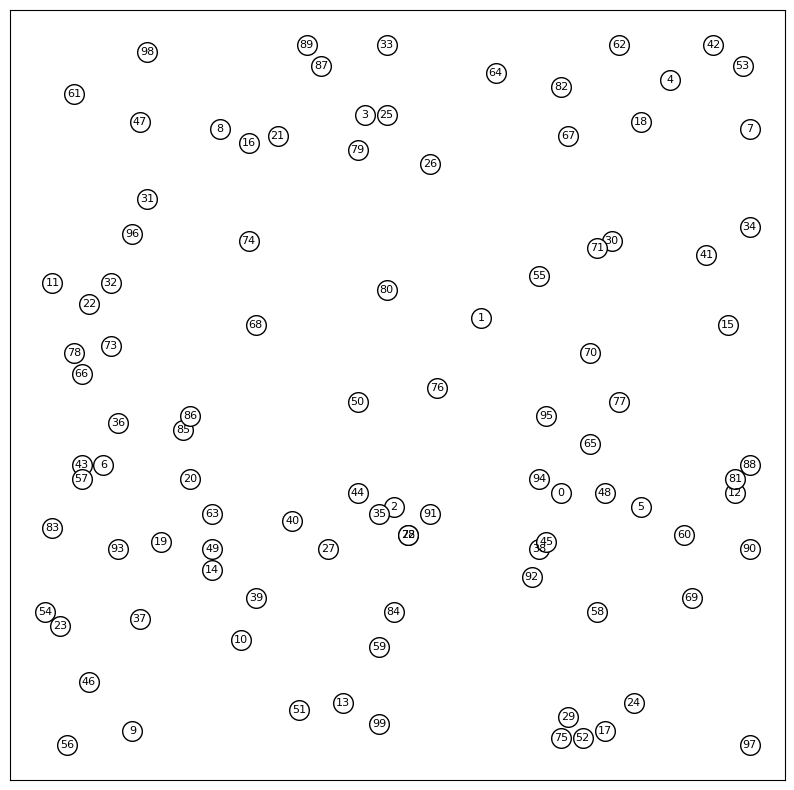

In [60]:
DrawSol(G,x)


In [ ]:

mtsp._graph = G
mtsp._vars = x



## SEC separation callback (Lazy Constraints)

In [ ]:
def SEC_lazy_callback (model, where):

    #
    # SEC Constraints of form 2 above
    #
        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
                        
        for i,j in G.edges():
            G[i][j]['capacity'] = xrel[i,j]
        
        for i in list(G.nodes())[2:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    cutarcs = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbLazy(gb.quicksum(x[i,j] for i,j in cutarcs) >= 1)
                    break
                

In [ ]:
mtsp.reset()
mtsp.Params.lazyConstraints = 1
mtsp.optimize(SEC_lazy_callback)

Discarded solution information
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 79 rows, 132 columns and 374 nonzeros
Model fingerprint: 0x61f9a0d6
Variable types: 0 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve time: 0.01s
Presolved: 79 rows, 132 columns, 374 nonzeros
Variable types: 0 continuous, 132 integer (132 binary)

Root relaxation: objective 1.247100e+04, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12471.0000    0    -          - 12471.0000      -     

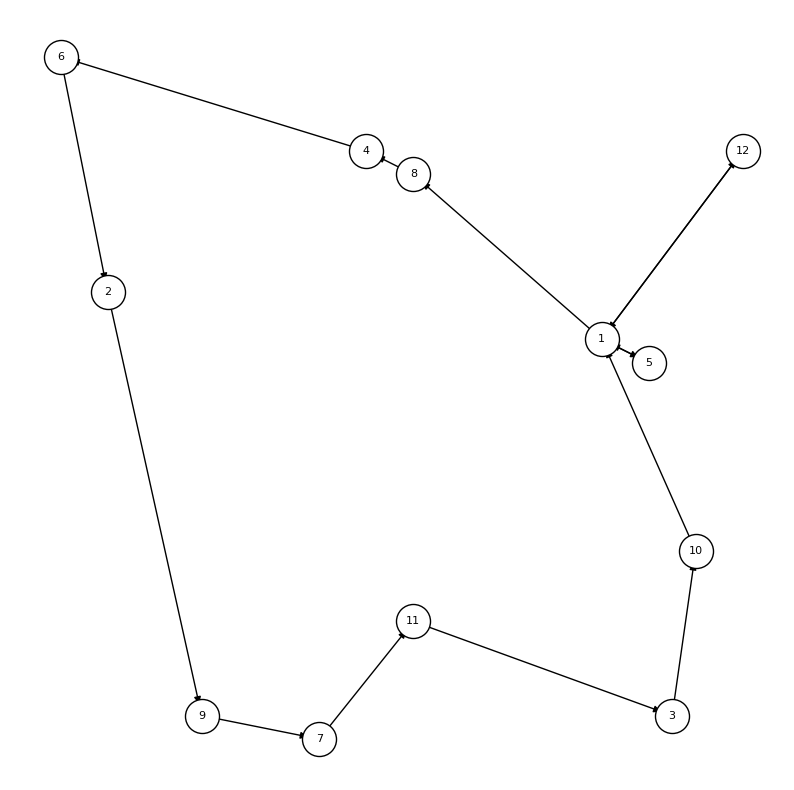

In [ ]:
DrawSol(G,x)

## mTSP MTZ constraints

### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j = 2}^{j=n} x_{1j} &= m  \;\; \text{(OUT-R)}\\
\sum_{i = 2}^{i=n} x_{i1} &= m \;\; \text{(IN-R)}\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N, i\not=1 \;\; \text{(RS)}\\
u_i - u_j + p x_{ij} &\le p-1 \;\; \forall (i,j) \in A, i,j \not = 1\\
x & \in \{0,1\}^{|A|}\\
        u_1 & = 0\\
        u & \ge 0
\end{alignat}
$$

In [ ]:
m = 3
p = 10



In [ ]:
mtsp_mtz = gb.Model()

x = mtsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = mtsp_mtz.addVars(G.nodes(), obj=0.0, vtype=gb.GRB.CONTINUOUS,\
                     lb=1.0, ub=p, name='u')

mtsp_mtz.write('mtsp_mtz.lp')

In [ ]:
mtsp_mtz.addConstr(x.sum(root,'*') == m, name = 'OUT-R')
mtsp_mtz.addConstr(x.sum('*',root) == m, name = 'IN-R')
mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [ ]:
mtsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() if i != root), name='FS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [ ]:
mtsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes() if i != root), name='RS')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [ ]:
mtsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i \
                     and i != root and j != root ), name='SUB2')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')

In [ ]:
u[root].lb = 0
u[root].ub = 0

In [ ]:
mtsp_mtz.addConstrs((u[i] - u[j] + p * x[i,j] <= p - 1 \
                     for i in G.nodes() for j in G.nodes()\
                    if i != j and i != root and j != root and G.has_edge(i,j)), name='MTZ')

mtsp_mtz.update()
mtsp_mtz.write('mtsp_mtz.lp')


mtsp_mtz._graph = G
mtsp_mtz._vars = x

In [ ]:
mtsp_mtz.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 189 rows, 144 columns and 704 nonzeros
Model fingerprint: 0xb2e6eed3
Variable types: 12 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 24679.000000
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 189 rows, 143 columns, 1415 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)

Root relaxation: objective 1.248598e+04, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 12485.9841    0   14 24679.0000 12

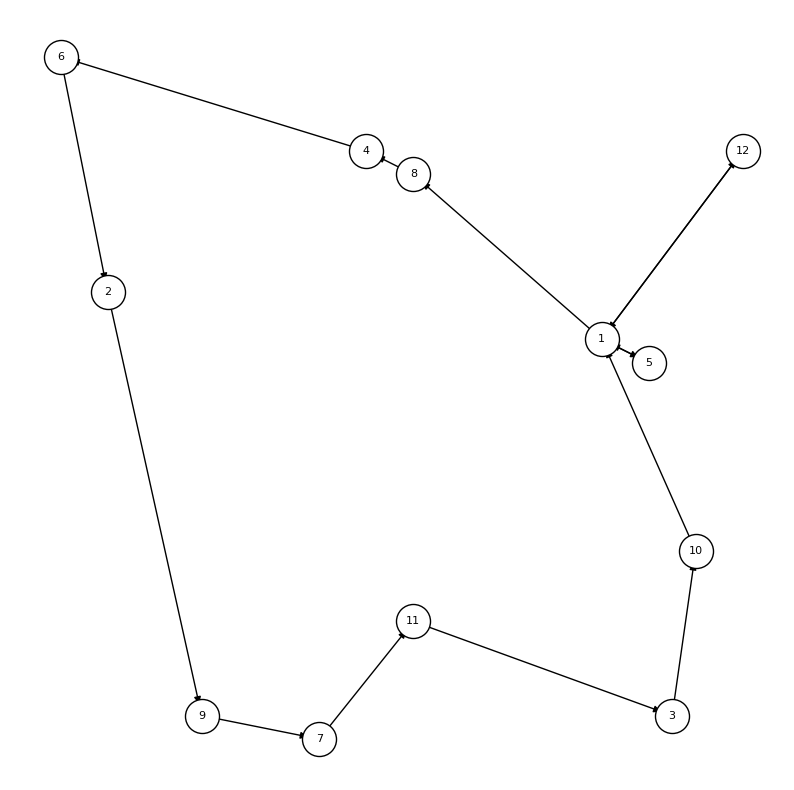

In [ ]:
DrawSol(G, x)

In [ ]:
u

{1: <gurobi.Var u[1] (value 0.0)>,
 2: <gurobi.Var u[2] (value 4.000000000000001)>,
 3: <gurobi.Var u[3] (value 8.0)>,
 4: <gurobi.Var u[4] (value 2.000000000000001)>,
 5: <gurobi.Var u[5] (value 1.0)>,
 6: <gurobi.Var u[6] (value 3.000000000000001)>,
 7: <gurobi.Var u[7] (value 5.999999999999998)>,
 8: <gurobi.Var u[8] (value 1.0)>,
 9: <gurobi.Var u[9] (value 4.999999999999997)>,
 10: <gurobi.Var u[10] (value 9.0)>,
 11: <gurobi.Var u[11] (value 6.999999999999999)>,
 12: <gurobi.Var u[12] (value 1.0)>}

## Formulation strengthening through the Cut Callback

In [ ]:
def SEC_cut_callback (model, where):

    #
    # SEC Constraints of form 2 above
    #


        
    if where == gb.GRB.Callback.MIPNODE:
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        count = model.cbGet(gb.GRB.Callback.MIPNODE_NODCNT)
        if status == gb.GRB.OPTIMAL and count < 10:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph
                        
            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:

                    cutarcs = [(u,v) for u in cut[0] for v in cut[1] if G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in cutarcs) >= 1)
                    break
                    


In [ ]:
mtsp_mtz.reset()
mtsp_mtz.Params.PreCrush = 1
mtsp_mtz.Params.lazyConstraints = 0



mtsp_mtz.optimize(SEC_cut_callback)


Discarded solution information
Set parameter PreCrush to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 189 rows, 144 columns and 704 nonzeros
Model fingerprint: 0xb2e6eed3
Variable types: 12 continuous, 132 integer (132 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+02, 4e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 24679.000000
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 189 rows, 143 columns, 1415 nonzeros
Variable types: 11 continuous, 132 integer (132 binary)

Root relaxation: objective 1.248598e+04, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

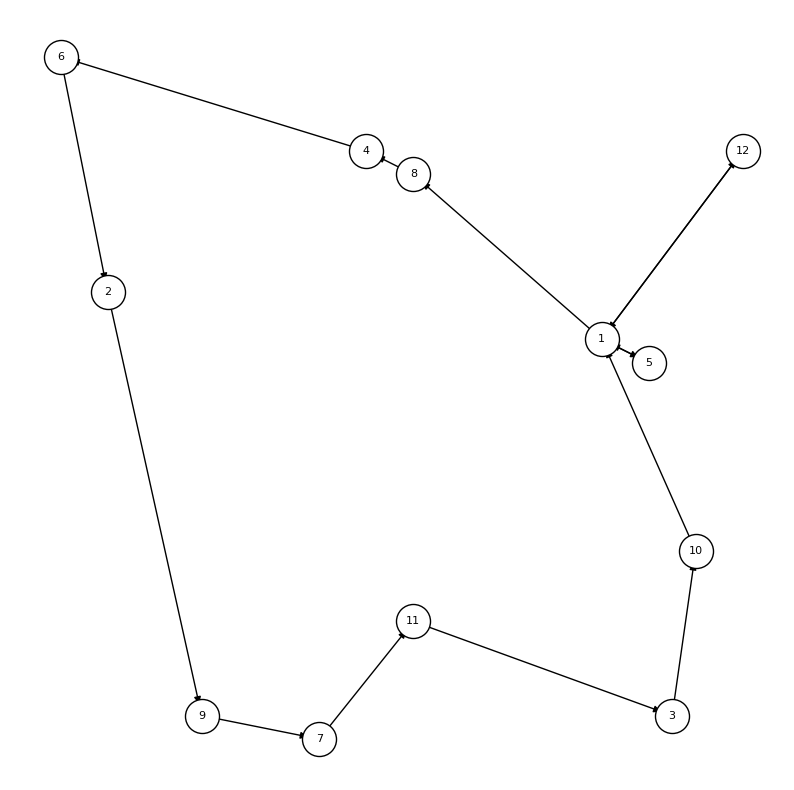

In [ ]:
DrawSol(G,x)


In [ ]:
u

{1: <gurobi.Var u[1] (value 0.0)>,
 2: <gurobi.Var u[2] (value 4.000000000000001)>,
 3: <gurobi.Var u[3] (value 8.0)>,
 4: <gurobi.Var u[4] (value 2.000000000000001)>,
 5: <gurobi.Var u[5] (value 1.0)>,
 6: <gurobi.Var u[6] (value 3.000000000000001)>,
 7: <gurobi.Var u[7] (value 5.999999999999998)>,
 8: <gurobi.Var u[8] (value 1.0)>,
 9: <gurobi.Var u[9] (value 4.999999999999997)>,
 10: <gurobi.Var u[10] (value 9.0)>,
 11: <gurobi.Var u[11] (value 6.999999999999999)>,
 12: <gurobi.Var u[12] (value 1.0)>}